# Identifying Regressed Queries with Azure Database for PostgreSQL Intelligent Performance
 
## Introduction
One of the challenges associated with monitoring and alerting is to filter out noise from the signal. Nobody wants to receive a midnight call by an automated alert for an issue that turns out to be a false positive. Nor do we want to lose hours sorting through issues to locate a starting point from which to triage. At any point, if you suffer from a slowdown in your workload, one way to digest the overall problem space is to review your top regressed queries using a dash of statistics. Doing so gives you a chance to rule out differences that are more likely to be “coincidental” so that you can concentrate on issues that are statistically significant. 

In his blog post [Operationalizing your PostgreSQL database health checks using SQL Notebooks](https://azure.microsoft.com/en-us/blog/operationalizing-your-database-health-checks-using-sql-notebooks/), Parikshit Savjani describes a great way to [using notebooks in Azure Data Studio](https://docs.microsoft.com/en-us/sql/azure-data-studio/sql-notebooks?view=sql-server-2017) to operationalize PostgreSQL health checks. If you have started with basic health checks in your notebook, the exercise of extending your setup with the regressed queries scenario will rather be easy for you.
 
## Getting started
* Install [Azure Data Studio](https://docs.microsoft.com/en-us/sql/azure-data-studio/download?view=sql-server-2017)
* Clone this repo or simply copy the notebook and the requirements.txt file into a local folder of your choice
* Open the folder in Azure Data Studio [CTRL + K CTRL + O]
* [Configure](https://docs.microsoft.com/en-us/sql/azure-data-studio/sql-notebooks?view=sql-server-2017#manage-packages) local Python kernel for Notebooks by switching the kernel to Python 3.
* Have an Azure Database for PostgreSQL instance configured as needed below.
* Update required paramaters within the notebook per blow
* Run your notebook

## Configure your database
You need to ensure below server settings for data collection to start.
* Go into Server parameters parameters blade on Azure portal
* Set pg_qs.track_utility to on
* Set pg_qs.query_capture_mode to top or all
* Set pgms_wait_sampling.query_capture_mode to all
 
<b>Please note that the supported versions are 9.6 and above</b>

## Install required libraries
* Click on 'Install Packages' at the top of the notebook
* Run '.\python.exe -m pip install -r full_path_to_the_requirements_file\requirements.txt in terminal window

## Update your parameters
You will need to update the parameters indicated by the following based on your needs before you run your notebook.

    #############
    # update here
    #############

### What do these parameters mean?
* > baseline_period_start & baseline_period_end identify a window of measurements where you think the performance can be baselined
* > current_period_start & current_period_end identify the window of measurements that you want to compare against your baseline
* > significance_level is also commonly known as alpha in hypothesis testing. [It](https://en.wikipedia.org/wiki/Statistical_significance) is a measure of probability rejecting the null hypothesis while it is true. The typical value is 0.05.
* > directional_preference is a parameter to indicate direction of interest. You should choose 1 for increase, -1 for decrease and 0 for any direction of change between baseline and current period.
* > percent_change_threshold is a constant that can help you single out only percent changes above this value
* > output_file_path is a local path to output your results if there is any significant changes
* > host is in format similar to "yourdb.postgres.database.azure.com" and can be located at the overview blade of your instance in Azure portal
* > user should be similar to "youruser@yourdb" format

### I ran the notebook, now what?
You can play with the parameters to adjust your sensitivity but the output should give you regressed query candidates, if your directional_preference is +1. Once you identified your regressed queries, your next step is to understand why your queries actually regressed. There can be a number of reasons why you would experience regression in PostgreSQL. Here are a few usual suspects for you:
* Is your table statistics current? Query optimizer leverages the statistics for your table deciding an optimal plan for your query. Perhaps it's time for you to run an ANALYZE to update the stats
* Is autovacuum catching up properly to clean your bloat? There are a number of settings that controls how and when a worker starts and stops working on reclaiming dead tuples on pages. Having excessive bloat might impact what can be fit into memory and reduce your workload's effectiveness.
* Are you hitting cache while querying your tables? If your queries are increasingly reading from disk, there sure is a missed opportunity for you to optimize performance.
* Do you have proper indices? Perhaps a deployment caused an index to unintentionally drop or maybe application users are interested in your tables with a brand new perspective. Make sure to use [Intelligent Performance Index Advisor](https://docs.microsoft.com/en-us/azure/postgresql/concepts-performance-recommendations) to see if there are indices you can benefit from.
* Has your data size or number of records drastically changed? Perhaps your baseline expectations should adjust to your new data size. Nonetheless, it's great to keep track of this.
* Have the locks been at steady state or has there been any changes? Are there any significant differences? Locate the root cause to get that performance win!
* What's the network latency? Have you run a 'select 1' to see what the network latency is? Perhapse it's not your database engine that is the issue.
* Could you be running this query elsewhere? Is this a read-only query? May be you should route this query to a replica to improve overall workload performance.

Well, there are quite a number of follow-up questions that can lead you to your next step. This is only one of the first possible steps in your detective work. Good luck and let us know how you improved this notebook!

In [33]:
# data access related functions

def get_connection():
    # construct connection string
    conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)
    conn = psycopg2.connect(conn_string) 
    return conn

def get_connection_to_azure_sys():
    # construct connection string
    conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, azuresysdbname, password, sslmode)
    conn = psycopg2.connect(conn_string) 
    print ("Connection established")
    return conn

def get_cursor(conn):
    cursor = conn.cursor()
    return cursor

def commit_close(conn,cursor):
    # cleanup
    conn.commit()
    cursor.close()
    conn.close()
    print ("Connection closed")

def rollback_close(conn,cursor):
    # cleanup
    conn.rollback()
    cursor.close()
    conn.close()
    print ("Rollback completed and connection closed")

In [34]:
# import required libraries. if your environment does not have these libraries, refer to 'Install Required Libraries' section above

import psycopg2, re, sys, time
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import matplotlib.backends.backend_pdf
import matplotlib.pyplot as plt

In [35]:
# update your database info

# ###########
# update here
# ###########
host = "yourdb.postgres.database.azure.com"
user = "youruser@yourdb"
# dbname = "yourdb"
azuresysdbname = "azure_sys"
password = "***"
sslmode = "require"

In [36]:
# check records in your query store to ensure that there are stats to work with. if no data, ensure that your server parameters is set to what's listed above

conn = get_connection_to_azure_sys()
cursor = get_cursor(conn)
t0 = time.time()
cursor.execute("SELECT count(*) FROM query_store.pgms_wait_sampling_view ws")
counter = cursor.fetchone()[0]
print('Count of wait statistics: %s'%counter)

cursor.execute("SELECT count(*) FROM query_store.qs_view qs")
counter = cursor.fetchone()[0]
print('Count of query statistics: %s'%counter)

t = time.time() - t0

commit_close(conn,cursor)

Connection established
Count of wait statistics: 11337


Count of query statistics: 20063
Connection closed



### Aggregate metrics
We will concentrate on query mean execution time in this exercise. The objective is to understand whether or not changes in a particular statistic to happen by chance or not. This will provide some level of confidence to go after a particular query to optimize.


In [37]:
# query templates

ws_metric_aggregation_grouped_by = 'with ordered_ws_aggregation as (select event_type ||\':\'|| event as group_by, start_time, db_id, sum(calls) metric from query_store.pgms_wait_sampling_view where start_time >= \'%s\' and start_time < \'%s\' group by event_type ||\':\'|| event, start_time, db_id order by db_id,group_by, start_time ) select db_id,group_by, array_agg(metric) as metric_value, array_agg(start_time) as timeseries from ordered_ws_aggregation group by db_id, group_by;'

qs_metric_aggregation_grouped_by = 'with ordered_qs_aggregation as (select query_id as group_by, query_sql_text, start_time, datname, %s(%s) as metric from query_store.qs_view join pg_database on query_store.qs_view.db_id = pg_database.oid where start_time >= \'%s\' and start_time < \'%s\' group by group_by, query_sql_text, start_time, datname order by datname,group_by, start_time )select datname as database_name,group_by, query_sql_text, array_agg(metric) as metric_value, array_agg(start_time) as timeseries from ordered_qs_aggregation group by datname, group_by, query_sql_text;'


### Baseline vs. Current
We will need to indicate what is normal vs what is under test to do proper comparison. Please note that we have no validations in place but the test below has certain assumptions like independent distributions. Ensure that the periods do not intersect.

In [38]:
# update baseline and current period start and end times

# ###########
# update here
# ###########

baseline_period_start = '2018-08-01 10:00:00-07'
baseline_period_end = '2019-05-24 10:00:00-07'

current_period_start = '2019-05-24 10:00:00-07'
current_period_end = '2019-05-31 10:00:00-07'

conn = get_connection_to_azure_sys()
cursor = get_cursor(conn)
t0 = time.time()

#ws
#cursor.execute(ws_metric_aggregation_grouped_by % (baseline_period_start,baseline_period_end))
#baseline = pd.DataFrame(cursor.fetchall(), columns=['db_id', 'group_by', 'metric_distribution'])

#cursor.execute(ws_metric_aggregation_grouped_by % (current_period_start,current_period_end))
#current = pd.DataFrame(cursor.fetchall(), columns=['db_id', 'group_by', 'metric_distribution'])

#qs
cursor.execute(qs_metric_aggregation_grouped_by % ('sum','mean_time',baseline_period_start,baseline_period_end))
baseline = pd.DataFrame(cursor.fetchall(), columns=['database_name', 'group_by','description', 'metric_distribution','timeseries'])

cursor.execute(qs_metric_aggregation_grouped_by % ('sum','mean_time',current_period_start,current_period_end))
current = pd.DataFrame(cursor.fetchall(), columns=['database_name', 'group_by','description', 'metric_distribution','timeseries'])


t = time.time() - t0
commit_close(conn,cursor)

Connection established


Connection closed


In [39]:
# if you want to query what's in current and baseline, uncomment line and run 

# current
baseline

,database_name,group_by,description,metric_distribution,timeseries
0,postgres,827537244,CREATE TABLE msftpgbackupprobe(id int),"[3.46511634133694, 3.01381078307911, 3.1998962...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
1,postgres,961354038,ROLLBACK,"[0.00297498720011757, 0.00327248592012933, 0.0...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
2,postgres,1920309115,"SELECT\n date_trunc('seconds', now()) AS ...","[4.55158166681988, 4.0409251139197, 3.82746978...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
3,azure_sys,1447255847,select * from query_store.qs_view where mean_t...,"[766.746039325166, 744.259747322437, 751.05476...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
4,postgres,905422134,SELECT\n COUNT(*) filter (WHERE state in ('...,"[0.261352625530329, 0.247518935049782, 0.22654...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
5,azure_sys,3517577689,SET statement_timeout = 0,"[0.0142799385605643, 0.0144286879205702, 0.013...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
6,azure_sys,844424357,"SELECT\n rse.runtime_stats_entry_id,\n ...","[686.48350265473, 656.687964600032, 676.260405...","[2019-05-22 23:31:52+00:00, 2019-05-23 00:31:5..."
7,postgres,1917235712,set session statement_timeout to 5000,"[0.0062474731202469, 0.00669372120026454, 0.00...","[2019-05-23 00:31:52+00:00, 2019-05-23 02:31:5..."
8,postgres,2998726051,"SELECT\n ls.file_count,\n done.done_coun...","[1.64457292422499, 1.50638476877953, 1.7205838...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."
9,postgres,666004881,SELECT CAST(Count(*) AS integer) AS replicatio...,"[0.0209736597608289, 0.0223124040008818, 0.021...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5..."


In [40]:
# check if there are records to compare in either of the periods

if(len(baseline.index)>0 and len(current.index)>0):
    comparison_frame = pd.merge(baseline, current, how='right', left_on=['database_name','group_by'],right_on=['database_name', 'group_by'])
else:
    print('No records exist in one or more periods you specified. Please select ranges for which both baseline and current data exists')

In [41]:
# in case you are wondering, you may peek at the comparison data frame to see what's being compared

comparison_frame

,database_name,group_by,description_x,metric_distribution_x,timeseries_x,description_y,metric_distribution_y,timeseries_y
0,postgres,827537244,CREATE TABLE msftpgbackupprobe(id int),"[3.46511634133694, 3.01381078307911, 3.1998962...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",CREATE TABLE msftpgbackupprobe(id int),"[3.10172165484258, 3.45425763805651, 3.2738246...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
1,postgres,961354038,ROLLBACK,"[0.00297498720011757, 0.00327248592012933, 0.0...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",ROLLBACK,"[0.00282623784011169, 0.00446248080017636, 0.0...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
2,postgres,1920309115,"SELECT\n date_trunc('seconds', now()) AS ...","[4.55158166681988, 4.0409251139197, 3.82746978...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...","SELECT\n date_trunc('seconds', now()) AS ...","[4.86752530747236, 5.72774285638636, 2.8060079...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
3,azure_sys,1447255847,select * from query_store.qs_view where mean_t...,"[766.746039325166, 744.259747322437, 751.05476...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",select * from query_store.qs_view where mean_t...,"[795.448745581772, 786.349092733028, 779.73269...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
4,postgres,905422134,SELECT\n COUNT(*) filter (WHERE state in ('...,"[0.261352625530329, 0.247518935049782, 0.22654...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",SELECT\n COUNT(*) filter (WHERE state in ('...,"[0.177606735847019, 0.187870441687425, 0.22014...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
5,azure_sys,3517577689,SET statement_timeout = 0,"[0.0142799385605643, 0.0144286879205702, 0.013...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",SET statement_timeout = 0,"[0.0135361917605349, 0.0148749360005879, 0.014...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
6,azure_sys,844424357,"SELECT\n rse.runtime_stats_entry_id,\n ...","[686.48350265473, 656.687964600032, 676.260405...","[2019-05-22 23:31:52+00:00, 2019-05-23 00:31:5...","SELECT\n rse.runtime_stats_entry_id,\n ...","[394.338272109584, 733.427015680265, 656.66922...","[2019-05-24 17:32:04+00:00, 2019-05-24 18:47:0..."
7,postgres,1917235712,set session statement_timeout to 5000,"[0.0062474731202469, 0.00669372120026454, 0.00...","[2019-05-23 00:31:52+00:00, 2019-05-23 02:31:5...",set session statement_timeout to 5000,"[0.00803246544031744, 0.00713996928028217, 0.0...","[2019-05-24 17:32:04+00:00, 2019-05-24 19:47:0..."
8,postgres,2998726051,"SELECT\n ls.file_count,\n done.done_coun...","[1.64457292422499, 1.50638476877953, 1.7205838...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...","SELECT\n ls.file_count,\n done.done_coun...","[1.64263918254492, 6.49677704761675, 1.5038560...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."
9,postgres,666004881,SELECT CAST(Count(*) AS integer) AS replicatio...,"[0.0209736597608289, 0.0223124040008818, 0.021...","[2019-05-22 23:01:52+00:00, 2019-05-22 23:16:5...",SELECT CAST(Count(*) AS integer) AS replicatio...,"[0.0194117914807672, 0.0182961712807231, 0.020...","[2019-05-24 17:02:04+00:00, 2019-05-24 17:17:0..."


### Hypothesis
For the reasons of reliability in unequal variance or sample sizes, we will perform a [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test) to see if any of the change events are significant enough to take a look. Our null hypothesis will be that there is no change between the baseline period and the current period statistics. We will then test a one-sided alternative hypothesis for current period's aggregate metric's mean has increased.
 
>H0:μB−μC=0
 
>H1:μB<μC=0
 
We now need to calculate the p-value to determine if we can reject that the current period's measurement is the same as the baseline. If our p-value ends up being less than our threshold, we can be reasonably comfortable to invest more time to look at this alert and understand what is going on.

In [77]:
# update values below that satisfies your requirements
def reset_test_parameters():
    print('initializing test parameters')
    significantly_different_count = 0

    # set up general parameters for the test

    # ###########
    # update here
    # ###########
    significance_level = 0.05
    p_value_threshold = significance_level / 2
    directional_preference = 1 # -1 for decrease, +1 for increase, 0 for either way
    percent_change_threshold = 0.01 # filter out metric change between baseline to current below percent change. 0.01 means a 1% change
    output_file_path = "c:/tmp/output.pdf"
    
    print('looking for queries that changed %s percent from baseline to current period and testing for a p value threshold of %s percent'%(percent_change_threshold * directional_preference * 100, p_value_threshold * 100))
    return significantly_different_count, p_value_threshold, directional_preference, percent_change_threshold, output_file_path

initializing test parameters
looking for queries that changed 1.0 percent from baseline to current period and testing for a p value threshold of 2.0 percent
row 2 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 3 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 6 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 7 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 9 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 11 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 12 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 17 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 19 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 31 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

row 32 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 0  

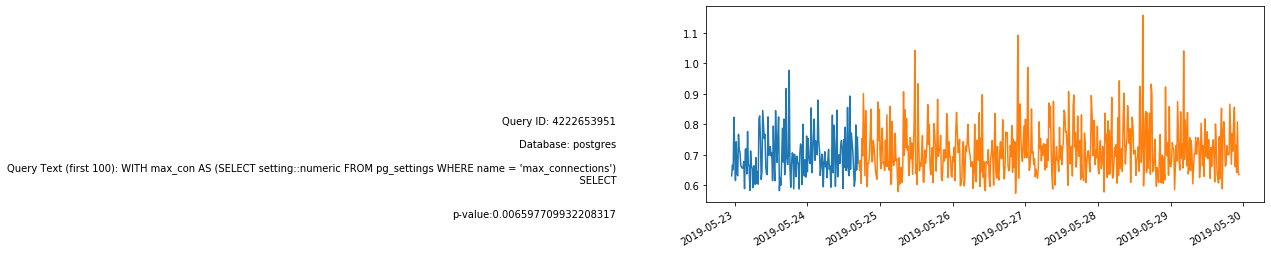

row 33 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 1  

row 35 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 1  

row 47 of 91 passed pre-requisites and tested: failed to reject null hypothesis - count of series with significant difference: 1  

Processing finished. You can locate output at c:/tmp/output.pdf 
Count of series with significant difference: 1 out of 91


c:\users\kileri\azuredatastudio-python\0.0.1\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  from ipykernel import kernelapp as app
c:\users\kileri\azuredatastudio-python\0.0.1\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\users\kileri\azuredatastudio-python\0.0.1\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [78]:
# unpack initialized test parameters
significantly_different_count, p_value_threshold, directional_preference, percent_change_threshold, output_file_path = reset_test_parameters()
total_record_count = len(comparison_frame.index)

pdf = matplotlib.backends.backend_pdf.PdfPages(output_file_path)

for index, row in comparison_frame.iterrows():
    
    # create distribution of metrics for baseline period and current period
    b = np.asarray(comparison_frame.iloc[index,3])
    c = np.asarray(comparison_frame.iloc[index,6])

    # compute the descriptive statistics of baseline (b) and current(c)
    # inspired by https://stackoverflow.com/a/22613361
    
    bbar = b.mean()
    bvar = b.var(ddof=1)
    nb = b.size
    bdof = nb - 1

    cbar = c.mean()
    cvar = c.var(ddof=1)
    nc = c.size
    cdof = nc - 1

    if (bdof<=0 or cdof<=0):
        continue
    
    # not enough population size for central limit theorem to hold        
    if (nb<30 or nc<30):   
        continue
    
    # filter out records that are not in the directional change you need
    if (directional_preference*(cbar-bbar)<0):
        continue
    
    # filter out records that have less of a change than your threshold
    if ((abs(cbar-bbar)/bbar)<percent_change_threshold):
        continue
        
    # use scipy.stats.ttest_ind's welch's t-test
    t, p = ttest_ind(b, c, equal_var=False, nan_policy = 'omit')
    
    # calculate one sided p value
    one_sided_p = p/2
    
    # compare the p value with your set threshold
    if (one_sided_p > p_value_threshold):
       result = 'failed to reject null hypothesis'
    elif (one_sided_p < p_value_threshold):
        #result = 'rejected null hypothesis; difference in current period is statistically significant.'
        significantly_different_count = significantly_different_count + 1
        baseline_series = pd.Series.from_array(comparison_frame.iloc[index,3],comparison_frame.iloc[index,4])
        current_series = pd.Series.from_array(comparison_frame.iloc[index,6],comparison_frame.iloc[index,7])

        
        fig, ax1 = plt.subplots(figsize=(10,4))
        baseline_series.plot(ax=ax1)

        current_series.plot(ax=ax1)
        fig.text(0,0.5,'Query ID: %s\n\nDatabase: %s\n\nQuery Text (first 100): %s\n\n\np-value:%s'%(comparison_frame.iloc[index,1],comparison_frame.iloc[index,0],comparison_frame.iloc[index,2][:100],p),ha='right',va='top')
                
        plt.show()
        
        pdf.savefig(fig, bbox_inches='tight')
    else:
        result = 'nan: omit processing'

    interim_status = 'row %s of %s passed pre-requisites and tested: %s - count of series with significant difference: %s '%(index + 1,total_record_count, result,significantly_different_count)
    print(interim_status, end=' ', flush=True)

if(significantly_different_count == 0):
    print('Processing finished. No significant difference identified with the periods and test parameters you defined.')
    pdf = None
else:    
    print('Processing finished. You can locate output at %s \nCount of series with significant difference: %s out of %s' %(output_file_path, significantly_different_count, total_record_count))
    pdf.close()


